# Table of contents
* [Word Tokenization](#word-tokenization)
    * [Most Common Words](#most-common-words)
    * [Feature Creation](#most-common-words-feature-creation)

In [1]:
import re # Regular expressions
import datetime # Date time operations
from os import path 
from PIL import Image
import urllib.request


# Standard data and visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sci-kit learn (machine learning)
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Natural learning toolkit
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer

# Library for generating wordclouds
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import the tweets dataset, this is a cut down version of the full tweet 
# dataset per the operations performed in the file "eda-rea-v-liv-2018"
en_tweets_df = pd.read_csv('en_tweets_df.csv', lineterminator='\n')

In [3]:
# As this dataset is generated from earlier work it carries its prior index, the below changes the column name
en_tweets_df.rename(columns={'Unnamed: 0':'original_df_index'}, inplace=True)

# Pre-processing <a class="anchor" id="word-tokenization"></a>

### Replace Swear Words <a class="anchor" id="word-tokenization"></a>

In [4]:
# Create a clean version of tweet solely for outputs, actual model will use all words
# rough approach as it has no impact on analysis. For example "massive" would become "m*profanity*ssive"
swear_words_file = open('swear_words.txt', 'r')
swear_words = [line.split(',') for line in swear_words_file.readlines()]
swear_words = [j for sub in swear_words for j in sub] 

def CleanTweet(tweet):
    tweet = tweet.lower()
    
    for word in swear_words:
        tweet = tweet.replace(word, '*profanity*')

    return tweet

en_tweets_df['clean_tweet'] = en_tweets_df.apply(lambda row: CleanTweet(row['tweet_text']), axis=1)

In [5]:
####################################################################################################
# While TfidfVectorizer and CountVectorizer are used later on, the below is used to pre-process
# the data and provide the data required to get some early insights into most common words.
####################################################################################################

# Create a function that returns tokenizes, cleans and stems words for a tweet
english_stopwords = stopwords.words('english')

# Context specific stop words (refer "most common words" section below for identification approach
# rt = short for retweet, this does not provide any insights and a column already exists to identify retweets
# http & https = the start of web links these provide little value as "words", future work: these could be
# to build a feature along thelines of "Contains Web Link?"
# uclfinal, championsleague, championsleaguefinal = "hashtag"/topical words, given the original tweet dataset
# contained only tweets that had a hashtag of uclfinal these words do not add value to the analysis
custom_stopwords = ['rt', 'http', 'https', 'uclfinal', 'championsleague', 'championsleaguefinal', 'lfcrma',  
                    'liverpoolvsrealmadrid', 'livrma', 'realiv', 'realliverpool', 'realmadridliverpool', 'realmadridvsliverpool', 
                    'rmalfc', 'rmaliv', 'rmavlfc', 'rmavliv', 'rmavsliv', 'rmliv', 'rmvsliv', 'retweet', 'retweeted']

ps = PorterStemmer()

# Combine the two stop words lists
stop_words = english_stopwords + custom_stopwords

def TokenizeTweet(tweet):
    word_tokenized = word_tokenize(tweet)

    
    cleaned_words_tokenized = [word.lower().strip() for word in word_tokenized] # lowercasing
    
    cleaned_words_tokenized = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', word) for word in cleaned_words_tokenized] # remove URLs
    cleaned_words_tokenized = [re.sub('@[^\s]+', 'AT_USER', word) for word in cleaned_words_tokenized] # remove usernames
    cleaned_words_tokenized = [re.sub(r'#([^\s]+)', r'\1', word) for word in cleaned_words_tokenized] # remove the # in #hashtag   
    cleaned_words_tokenized = [word.replace('(','').replace(')','') for word in cleaned_words_tokenized if word.isalpha()]  # replacing some unwanted things
    
    # Ideally all checks could be moved into this single for loop, rather than iterating words multiple times.
    for n, i in enumerate(cleaned_words_tokenized):
        # Standardise team names
        if i in ['liverpool', 'lfc', 'ufcliverpool', 'liv']:
            cleaned_words_tokenized[n] = 'liverpoolfc'
            
        if i in ['rma', 'madrid']:
            cleaned_words_tokenized[n] = 'realmadrid'
            
    cleaned_words_tokenized = [word for word in cleaned_words_tokenized if word not in stop_words] # removing stopwords
    cleaned_words_tokenized = [ps.stem(word) for word in cleaned_words_tokenized] # stemming
    
    return cleaned_words_tokenized

In [6]:
# Tokenize words in tweets
en_tweets_df['tokenized_words'] = en_tweets_df.apply(lambda row: TokenizeTweet(row['tweet_text']), axis=1)

In [7]:
en_tweets_df['tokenized_words'] 

0         [real, realmadrid, vs, liverpoolfc, liverpoolf...
1         [like, categor, state, sincer, commit, ensur, ...
2         [real, realmadrid, let, go, gon, na, arrog, pr...
3                                                   [pleas]
4                 [two, european, giant, go, win, laysunit]
                                ...                        
188082               [congrat, zizou, well, deserv, uclfin]
188083                [rememb, next, time, bad, day, kariu]
188084                          [annoy, fc, liverlona, fan]
188085    [laligaen, bale, fire, real, realmadrid, victo...
188086    [know, call, wwe, footbal, dirtiest, play, ser...
Name: tokenized_words, Length: 188087, dtype: object

### Most Common Words <a class="anchor" id="most-common-words"></a>

In [15]:
# There are three key benefits to finding the most common words:
    # 1. Further refinements could be made to TokenizedWords in terms of words to exclude
    # 2. We can obtain further insights into the data
    # 3. Can select key words that could be used to generate features    

# Convert tokenized words column into a single list of words
words_list = en_tweets_df['tokenized_words'].values.tolist()

# Flatten the list
flattened_words_list = [j for sub in words_list for j in sub]

# Find the most common words
fdist = FreqDist(x.lower() for x in flattened_words_list)
fdist.most_common(25)

[('liverpoolfc', 48196),
 ('salah', 37548),
 ('ramo', 31736),
 ('realmadrid', 28476),
 ('bale', 22325),
 ('goal', 21128),
 ('real', 20624),
 ('sergio', 14425),
 ('gareth', 11275),
 ('final', 10888),
 ('world', 8579),
 ('mo', 8537),
 ('kariu', 8418),
 ('one', 7910),
 ('ronaldo', 7447),
 ('cup', 7347),
 ('time', 7302),
 ('shoulder', 7209),
 ('game', 7119),
 ('like', 7022),
 ('win', 6609),
 ('score', 6590),
 ('ever', 6378),
 ('watch', 6345),
 ('come', 6275)]

# KMeans <a class="anchor" id="kmeans"></a>

### Loop <a class="anchor" id="loop"></a>

In [8]:
# Define dataframe for this analysis
df = en_tweets_df
df['flatten_tokenized_words'] = df.apply(lambda row: ' '.join(row['tokenized_words']), axis=1)

In [39]:
# Convert tokenized words column into a single list of words
words_list = df['tokenized_words'].values.tolist()

# Flatten the list
flattened_words_list = set([j for sub in words_list for j in sub])

# Get the number of distinct words in dataset
number_of_distinct_words = len(flattened_words_list)

In [40]:
# The below was used to output a varying number of clusters while also changing function parameters.
# This enabled review of the ouptuts to identify combinations providing good clusters that could be explored further.
# Loop through the feature creation changing the:
    # minimum df - When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
    # max_features - If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
    # k - Number of clusters
pd.options.mode.chained_assignment = None  # default='warn'

min_df = range(0, 11, 5) # Loop three times increasing the min_df each time 

max_features_split = round(number_of_distinct_words / 3) # Divide by 3 giving us groups to iterate through, decreasing the features used each iteration
max_features = range(number_of_distinct_words, max_features_split, -max_features_split)

K = range(6, 19, 6) # Number of clusters loop from 6-18 increments of 6
####################################
# FEATURE TYPE
####################################
# One of either COUNT-VEC or TF-IDF must be uncommented
#file_suffix = 'TF-IDF'
file_suffix = 'COUNT-VEC'

filename = f'{datetime.datetime.now()}-{file_suffix}.txt'

with open(filename, 'w') as f:
    ####################################
    # FEATURE CREATION
    ####################################
    for i in min_df:
        for j in max_features:
            if file_suffix == 'TF-IDF':
                v = TfidfVectorizer(min_df=i, max_features=j) # TF IDF
            else:
                v = CountVectorizer(min_df=i, max_features=j) # COUNT VECTORIZE
                
            X = v.fit_transform(df['flatten_tokenized_words'])

            ####################################
            # FIT AND PREDICT MODEL
            ####################################
            for k in K:
                kmeans = KMeans(n_clusters=k, random_state=8)
                kmeans.fit(X)
                y_kmeans = kmeans.predict(X)

                ####################################
                # PRINT SAMPLES
                ####################################
                y = pd.Series(y_kmeans)
                df['y'] = pd.Series(y)

                pd.set_option('display.max_colwidth', None)

                f.write(f'------------------------------------------------------------------------\n')
                f.write(f'------------------------------------------------------------------------\n')
                f.write(f'min_df = {i} ---- max_features = {j} ---- n_clusters = {k}\n')

                for l in range(0, k):
                    f.write(' \n')
                    f.write('******************************************\n')
                    f.write(f'Cluster {l}\n')
                    f.write('******************************************\n')
                    
                    try:
                      f.write(df['clean_tweet'][(df['y'] == l)].sample(5).to_string())
                    except:
                      f.write(df['clean_tweet'][(df['y'] == l)].head().to_string())
                    f.write('\n')

                f.write(f'------------------------------------------------------------------------\n')
                f.write(f'------------------------------------------------------------------------\n')

### Elbow Method <a class="anchor" id="elbow-method"></a>

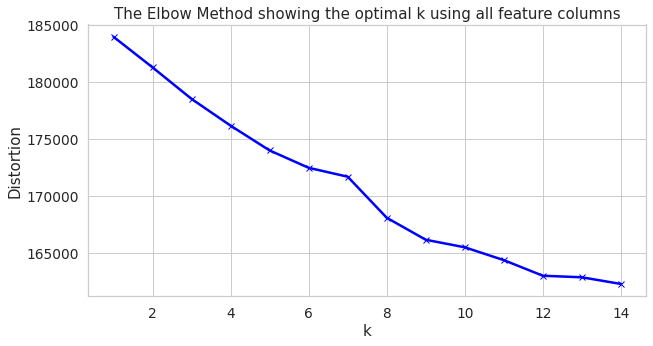

In [21]:
# The above showed strong results in TF-IDF for:
    # min_df = 0 ---- max_features = 25675 ---- n_clusters = 6 to 15

# Identify the optimal number of clusters (k), also considering the number of feature columns. 
pd.options.mode.chained_assignment = None  # default='warn'
K = range(1, 15)
distortions = []

for k in K:
    v = TfidfVectorizer(min_df=0, max_features=25675) # TF IDF
    # v = CountVectorizer(min_df=i, max_features=j) # COUNT VECTORIZE
    X = v.fit_transform(df['flatten_tokenized_words'])

    # Fit and predict model
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
        
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title(f'The Elbow Method showing the optimal k using all feature columns')
plt.show()

# Exploring clusters <a class="anchor" id="exploring-clusters"></a>

In [80]:
# Based on the elbow method, while there is not a totally clear point 8 appears most appropriate.
v = TfidfVectorizer(min_df=0, max_features=25675) # TF IDF
X = v.fit_transform(df['flatten_tokenized_words'])

# Fit and predict model
kmeans = KMeans(n_clusters=8, random_state=8)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y = pd.Series(y_kmeans)
df['y'] = pd.Series(y)

### PCA <a class="anchor" id="pca"></a>

In [ ]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################

### Samples from clusters <a class="anchor" id="samples-from-clusters"></a>

In [81]:
# Print samples from each cluster, RTs that are identified as RTs are not printed for illustrative purposes
# and to provide a range of tweet examples.

for l in range(0, 8):
    pd.set_option('display.max_colwidth', None)
    print('******************************************\n')
    print(f'Cluster {l}\n')

    try:
      print(df['clean_tweet'][(df['y'] == l) & (df['is_retweet'] == False)].sample(5).to_string())
    except:
      print(df['clean_tweet'][(df['y'] == l) & (df['is_retweet'] == False)].head().to_string())
    
# Cluster topics:
    # Cluster 0 - No particular topic
    # Cluster 1 - Bale wonder goal
    # Cluster 2 - Sympathy for Salah
    # Cluster 3 - Dislocated shoulder for Salah
    # Cluster 4 - No particular topic
    # Cluster 5 - Negativity towards Ramos
    # Cluster 6 - Bale wonder goal
    # Cluster 7 - Negativity towards Ramos

******************************************

Cluster 0

36122     that looks bad for salah. never ever i would wish for an injury to any player with #fifaworldcup coming up. #uclfinal #rmavliv
104279                                                                          huge miss by isco.. very lucky liverpool there #uclfinal
99248                                               absolutely gutted for mo, i'm sure he'll come back stronger next year @lfc #uclfinal
113528                                                                                                    yesss come on maneee #uclfinal
115391                                                                                                               goodness! #uclfinal
******************************************

Cluster 1

171654                                                                           gareth bale: i didn't come here to play. no, i didnt come here to observe. #uclfinal
133157    vamoossssss!\n \ngoooaalll!\n

### Distributions <a class="anchor" id="distributions"></a>

<AxesSubplot:xlabel='y'>

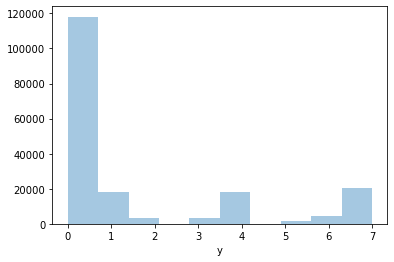

In [89]:
# Tweets per cluster, retweets also
# Count of features in cluster
sns.distplot(df.y, kde=False, bins=10)
################################################################################################
################################################################################################
################################################################################################
################################################################################################

### Visualisation <a class="anchor" id="Visualisation"></a>

In [ ]:
# Boxplot horiz with timeseries - mabe go above...
################################################################################################
################################################################################################
################################################################################################
################################################################################################

### Wordcloud <a class="anchor" id="wordcloud"></a>

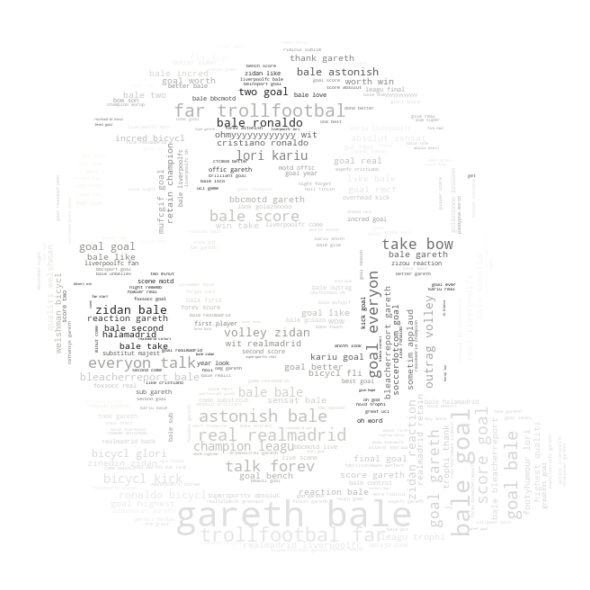

In [77]:
####################################
# CHAMPIONS LEAGUE BALL WORDCLOUD
####################################

# Read the mask / color image linked in url
url = 'https://images.redbullshop.com/is/image/RedBullSalzburg/RB-product-detail/RBL19307_9A_1/RBL-Champions-League-Ball.jpg'
image = np.array(Image.open(urllib.request.urlopen(url)))

# Define wordcloud parameters and exclude swear word
wc = WordCloud(background_color="white", max_words=300, mask=image,
               stopwords=swear_words, max_font_size=40, random_state=3)

# Only cluster 1 is included, this cluster is rich in words and has a very clear topic
wc.generate(' '.join(df['flatten_tokenized_words'][df['y']==1]))

# Create coloring from image
image_colors = ImageColorGenerator(image)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

------------------------------------------------------------------------


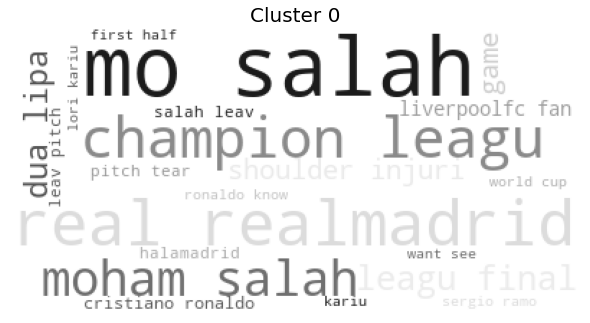

------------------------------------------------------------------------


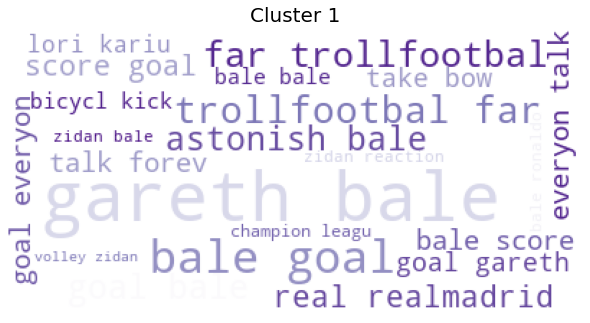

------------------------------------------------------------------------


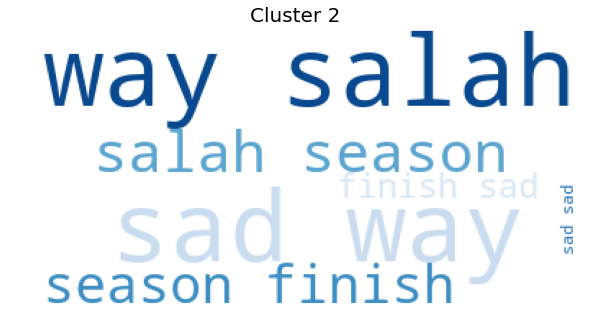

------------------------------------------------------------------------


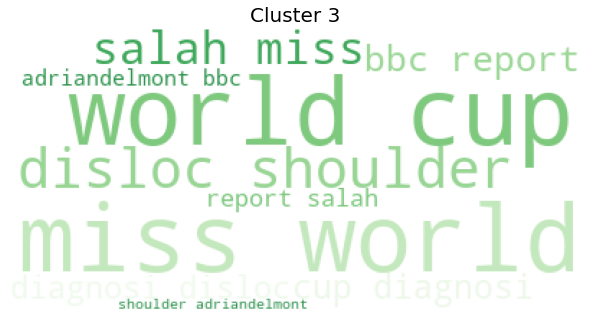

------------------------------------------------------------------------


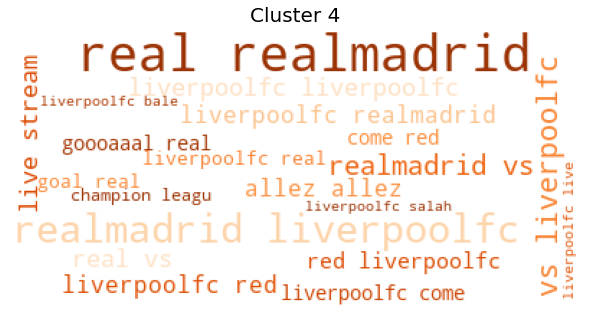

------------------------------------------------------------------------


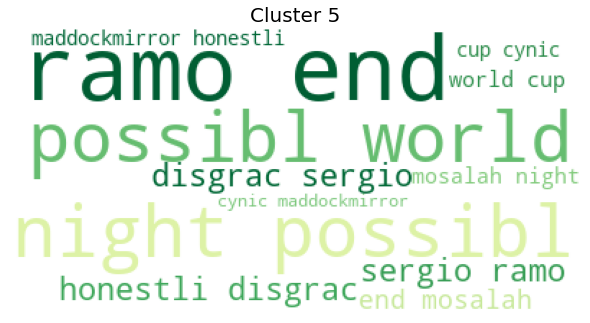

------------------------------------------------------------------------


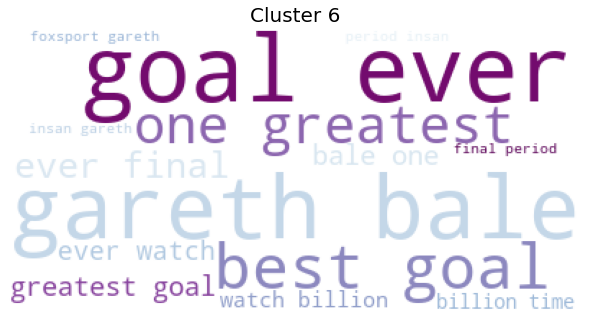

------------------------------------------------------------------------


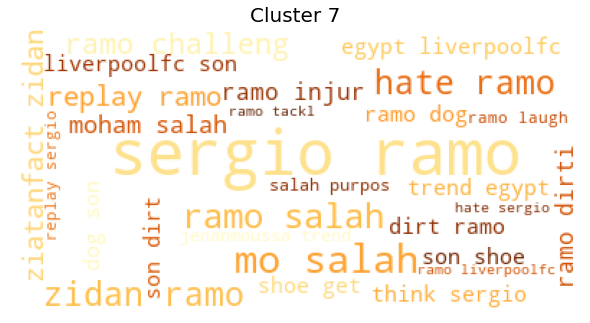

In [76]:
####################################
# CHAMPIONS LEAGUE BALL WORDCLOUD
####################################
sequential_cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'YlGn', 'BuPu', 'YlOrBr']

for l in range(0, 8):
    wc = WordCloud(background_color="white", max_words=300, stopwords=swear_words, min_font_size=10, random_state=3, colormap=sequential_cmaps[l])
    wc.generate(' '.join(df['flatten_tokenized_words'][df['y'] == l]))

    plt.figure(figsize = (8, 6)) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(label=f'Cluster {l}', fontsize=20)
    print('------------------------------------------------------------------------')
    plt.show()

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------
# Useful snippets etc.

In [ ]:
###############################################################
# Memory usage https://stackoverflow.com/questions/16261240/releasing-memory-of-huge-numpy-array-in-ipython/16278056
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
# Print a number of tweets for each cluster
# y = pd.Series(y_kmeans)
# df_tweet_y = pd.DataFrame(en_tweets_df)
# df_tweet_y['y'] = pd.Series(y)

# pd.set_option('display.max_colwidth', None)

# print(f'------------------------------------------------------------------------')
# print(f'------------------------------------------------------------------------')
# # print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
# print(f'Data shape = {X.shape}')

# for i in range(0, k):
#     print(f'****************************************** \n Cluster {i}')
#     print('******************************************')
#     print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i)].sample(15).to_string())
#     print('****************************************** \n')

# print(f'------------------------------------------------------------------------')
# print(f'------------------------------------------------------------------------\n\n\n')

In [ ]:
# Return 3 - 10 clusters for cummulative sets of 25 columns, the first 25 are the most common words
# for k in range(3, 11):
#     for num_of_FT_cols in range(25, 501, 25):
#         # Create X ensuring only records that have at least one of the features are included
#         X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
#         X['sum_of_FT_cols'] = X.sum(axis=1)
#         X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

#         # Fit and predict model
#         kmeans = KMeans(n_clusters=k, random_state=8)
#         kmeans.fit(X)
#         y_kmeans = kmeans.predict(X)
        
#         # Print a number of tweets for each cluster
#         y = pd.Series(y_kmeans)
#         df_tweet_y = pd.DataFrame(en_tweets_df_with_features)
#         df_tweet_y['y'] = pd.Series(y)

#         pd.set_option('display.max_colwidth', None)
        
#         print(f'------------------------------------------------------------------------')
#         print(f'------------------------------------------------------------------------')
#         print(f'k = {k} ---- Number of FT cols = {num_of_FT_cols}')
#         print(f'Data shape = {X.shape}')

#         for i in range(0, k):
#             print(f'****************************************** \n Cluster {i}')
#             print('******************************************')
#             print(df_tweet_y['tweet_text'][(df_tweet_y['y'] == i) & (df_tweet_y['is_retweet'] == False)].sample(5).to_string())
#             print('****************************************** \n')
            
#         print(f'------------------------------------------------------------------------')
#         print(f'------------------------------------------------------------------------\n\n\n')

In [ ]:
# Based on the above diagrams 7 clusters with 225 looks like it could hold some insights
# Create X ensuring only records that have at least one of the features are included
# k = 6
# X = en_tweets_df[cols]
# # X['sum_of_FT_cols'] = X.sum(axis=1)
# # X = X[cols][X['sum_of_FT_cols'] != 0]

# # Fit and predict model
# kmeans = KMeans(n_clusters=k, random_state=8)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

In [ ]:
# # Identify the optimal number of clusters (k), also considering the number of feature columns. This should assist in review of the cluster samples output.
# pd.options.mode.chained_assignment = None  # default='warn'
# K = range(3, 11)
# for num_of_FT_cols in range(25, 251, 25):
#     distortions = []
#     for k in K:
#         # Create X ensuring only records that have at least one of the features are included
#         X = en_tweets_df_with_features[cols[:num_of_FT_cols]]
#         X['sum_of_FT_cols'] = X.sum(axis=1)
#         X = X[cols[:num_of_FT_cols]][X['sum_of_FT_cols'] != 0]

#         X_scaled = preprocessing.scale(X)

#         # Fit and predict model
#         kmeans = KMeans(n_clusters=k, random_state=8)
#         kmeans.fit(X_scaled)
#         distortions.append(kmeans.inertia_)
        
#     plt.figure(figsize=(10, 5))
#     plt.plot(K, distortions, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Distortion')
#     plt.title(f'The Elbow Method showing the optimal k with {num_of_FT_cols} feature columns')
#     plt.show()

In [ ]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
# reduced_data = PCA(n_components=2).fit_transform(X)
# results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

# plt.figure(figsize=(40,30))
# sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
# plt.title('K-means Clustering')
# plt.show()

In [ ]:
# pd.options.mode.chained_assignment = None  # default='warn'

# distortions = []

# K = range(3, 11)
# for k in K:
#     X = x

#     # Fit and predict model
#     kmeans = KMeans(n_clusters=k, random_state=8)
#     kmeans.fit(X)
#     distortions.append(kmeans.inertia_)
        
# plt.figure(figsize=(10, 5))
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title(f'The Elbow Method showing the optimal k with')
# plt.show()